# General Motors Stock Price Analysis

## Plotting Price

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera, kstest, norm, probplot

data = pd.read_csv("/content/General Motors Stock Price History.csv", parse_dates=['Date'])
data.sort_values('Date', inplace=True)



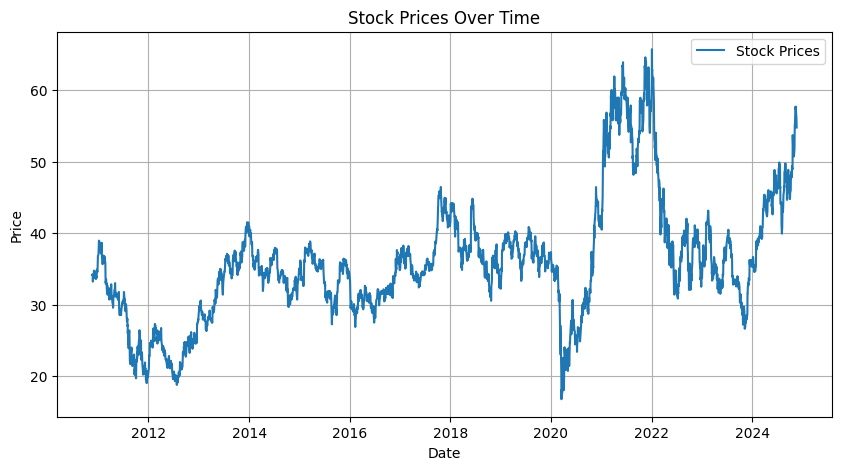

In [67]:
# Plot stock prices

plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Price'], label='Stock Prices')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Log Returns

In [3]:

# Calculate log-returns
data['Log_Returns'] = np.log(data['Price'] / data['Price'].shift(1))

# Drop NaN values from log-returns
data = data.dropna()



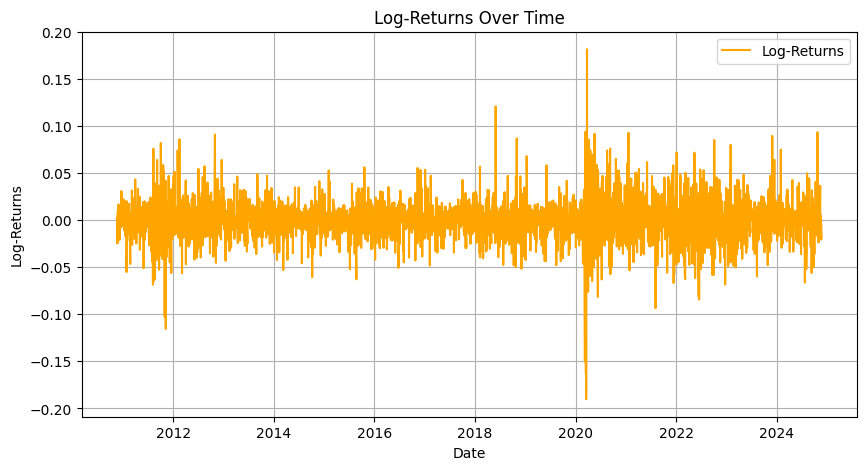

In [69]:
# Plot log-returns
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Log_Returns'], label='Log-Returns', color='orange')
plt.title('Log-Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log-Returns')
plt.legend()
plt.grid()
plt.show()




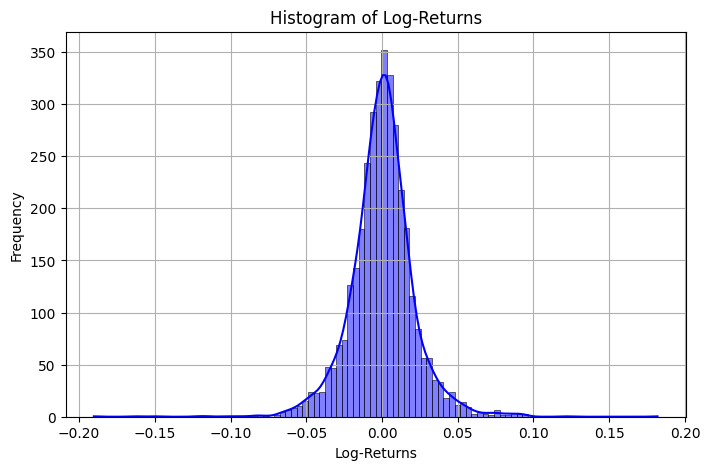

In [11]:
# Histogram of log-returns
plt.figure(figsize=(8, 5))
sns.histplot(data['Log_Returns'], kde=True, bins=100, color='blue')
plt.title('Histogram of Log-Returns')
plt.xlabel('Log-Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()

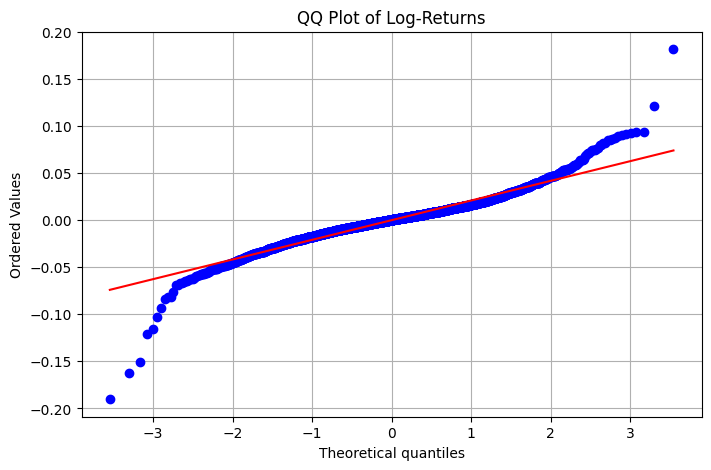

In [71]:

# QQ Plot
plt.figure(figsize=(8, 5))
probplot(data['Log_Returns'], dist="norm", plot=plt)
plt.title('QQ Plot of Log-Returns')
plt.grid()
plt.show()



**Observations:**

The distribution looks approximately like a normal distribution but has sharp peak.
- Extreme events ( crashes or surges) are rare, although in real markets, fat tails or deviations from normality are common.
- The peak of the distribution around 0 seems sharper than a standard normal distribution, suggesting that small daily changes are more frequent than a normal distribution predicts


## Statistical Tests

In [6]:

# Statistical Tests
# Jarque-Bera Test

jb_stat, jb_p = jarque_bera(data['Log_Returns'])
print(f"Jarque-Bera Test: Statistic={jb_stat}, p-value={jb_p:2f}")

# Kolmogorov-Smirnov Test
ks_stat, ks_p = kstest(data['Log_Returns'], 'norm', args=(data['Log_Returns'].mean(), data['Log_Returns'].std()))
print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}")

# Conclusion based on tests\
print('\nObservations:\n ')
if jb_p > 0.05:
    print("Jarque-Bera test: Log-returns are likely normally distributed (fail to reject H0).")
else:
    print("Jarque-Bera test: Log-returns are not normally distributed (reject H0).")

if ks_p > 0.05:
    print("Kolmogorov-Smirnov test: Log-returns are likely normally distributed (fail to reject H0).")
else:
    print("Kolmogorov-Smirnov test: Log-returns are not normally distributed (reject H0).")

Jarque-Bera Test: Statistic=7079.178383764759, p-value=0.000000
Kolmogorov-Smirnov Test: Statistic=0.06754115696626428, p-value=2.0177535938619223e-14

Observations:
 
Jarque-Bera test: Log-returns are not normally distributed (reject H0).
Kolmogorov-Smirnov test: Log-returns are not normally distributed (reject H0).


**Observations:**

While the log-returns show a bell-shaped curve, the p-value from the Jarque-Bera test confirms significant deviations from normality, primarily due to the fat tails and sharp peak. This is consistent with real-world financial data, where extreme price movements occur more frequently than predicted by normal distributions.

## **Volitility Estimation**

- Historical Volitility
- GARCH

In [73]:
#Historical Volititlity

closing_prices = data['Price']

closing_prices = pd.to_numeric(closing_prices, errors='coerce').dropna()
close=np.array(closing_prices)
log_returns = np.log(closing_prices / closing_prices.shift(1))

historical_volatility = np.std(log_returns) * np.sqrt(252)
print(f"Historical volatility (annualized): {historical_volatility:.4f}")


Historical volatility (annualized): 0.3424


## Using GARCH Model to estimate volitility

In [ ]:
pip install arch

[*********************100%***********************]  1 of 1 completed


                       Zero Mean - GARCH Model Results                        
Dep. Variable:            Log-Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:                736.559
Distribution:                  Normal   AIC:                          -1467.12
Method:            Maximum Likelihood   BIC:                          -1456.57
                                        No. Observations:                  249
Date:                Thu, Nov 21 2024   Df Residuals:                      249
Time:                        10:55:12   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1952e-06  9.112e-10   3506.669      0.000 

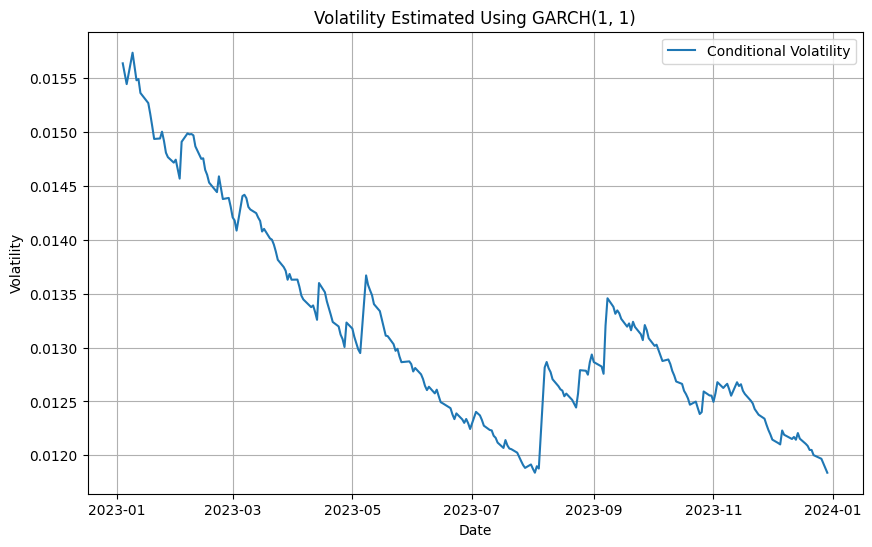

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
import warnings

# Disable all warnings
warnings.filterwarnings('ignore')

# Step 1: Download Historical Data
ticker = 'AAPL'  # Replace with your asset ticker
data = yf.download(ticker, start='2023-01-01', end='2024-01-01')
data['Log-Returns'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Step 2: Define the GARCH(1, 1) Model
returns = data['Log-Returns'].dropna()  # Remove NaN values
model = arch_model(returns, vol='Garch', p=1, q=1, mean='Zero', dist='normal')

# Step 3: Fit the Model
garch_result = model.fit(disp='off')  # Suppress optimization output
print(garch_result.summary())

# Step 4: Get Conditional Volatility
conditional_volatility = garch_result.conditional_volatility

# Step 5: Plot Volatility
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(conditional_volatility):], conditional_volatility, label="Conditional Volatility")
plt.title('Volatility Estimated Using GARCH(1, 1)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()


Observations:

Model Performance
Significance:

- The model is well-specified in terms of capturing volatility persistence (significant β).
- However, the insignificant α implies that the model may not fully capture the effect of sudden shocks on volatility.

### Computing annualized mean volitility and annualized recent volitility

In [53]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import warnings

# Disable all warnings
warnings.filterwarnings('ignore')

# Step 1: Load Data and Compute Log-Returns
ticker = 'AAPL'  # Replace with your asset ticker
data = yf.download(ticker, start='2023-01-01', end='2024-01-01')
data['Log-Returns'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Step 2: Fit the GARCH(1, 1) Model
returns = data['Log-Returns'].dropna()
model = arch_model(returns, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
garch_result = model.fit(disp='off')  # Fit the model

# Step 3: Extract Conditional Volatility
conditional_volatility = garch_result.conditional_volatility

# Option 1: Most Recent Volatility (last value)
recent_volatility = conditional_volatility.iloc[-1]

# Option 2: Mean Volatility (over the entire dataset or a specific period)
mean_volatility = conditional_volatility.mean()

# Step 4: Annualize Volatility (if needed)
# Assuming 252 trading days in a year for daily returns
recent_volatility_annualized = recent_volatility * np.sqrt(252)
mean_volatility_annualized = mean_volatility * np.sqrt(252)

print(f"Recent Volatility: {recent_volatility:.6f}")
print(f"Annualized Recent Volatility: {recent_volatility_annualized:.6f}")
print(f"Mean Volatility: {mean_volatility:.6f}")
print(f"Annualized Mean Volatility: {mean_volatility_annualized:.6f}")


[*********************100%***********************]  1 of 1 completed

Recent Volatility: 0.011838
Annualized Recent Volatility: 0.187930
Mean Volatility: 0.013150
Annualized Mean Volatility: 0.208747


##**Risk Free Rate for 3 Months**
## 4.62
Source: [Ycharts](https://ycharts.com/indicators/3_month_treasury_rate#:~:text=3%20Month%20Treasury%20Rate%20is%20at%204.63%25%2C%20compared,higher%20than%20the%20long%20term%20average%20of%202.75%25.)


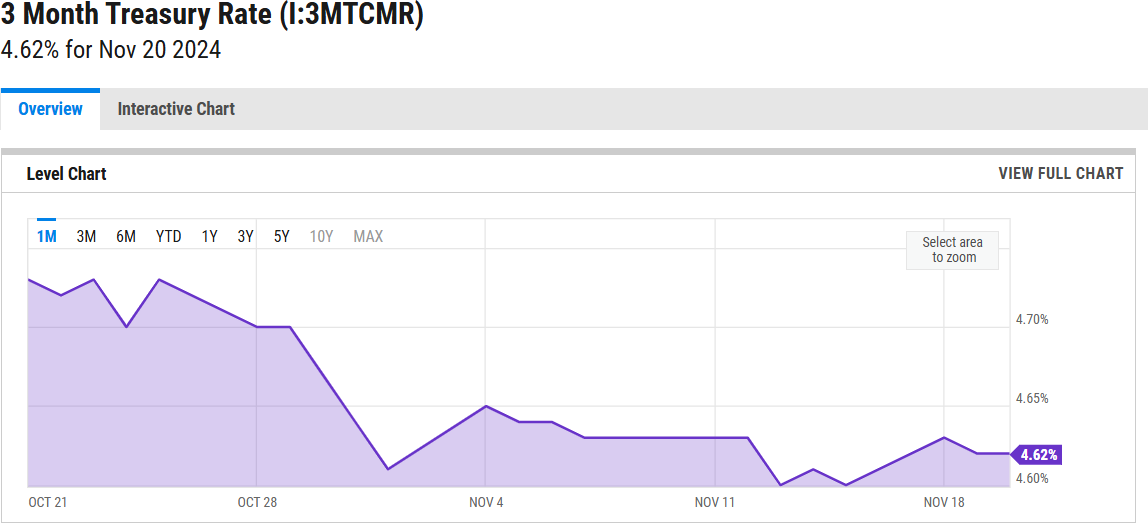

## **Correlation Test**

### Plotting Autocorrelation Function (ACF)


In [11]:
data.shape

(3524, 8)

<Figure size 1000x500 with 0 Axes>

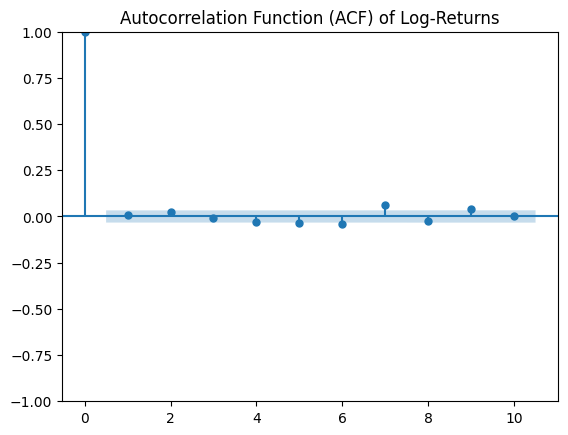

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot the ACF for log-returns
plt.figure(figsize=(10, 5))
plot_acf(data['Log_Returns'], lags=10, alpha=0.05)  # 60 lags close to root of number of rows, 95% confidence
plt.title('Autocorrelation Function (ACF) of Log-Returns')
plt.show()


- The autocorrelation at lag 0 is always 1.0, as any time series is perfectly correlated with itself.
-The autocorrelation values for all other lags (1 to 60 in this case) are very close to 0, with most points falling within the confidence interval (the shaded region).
This indicates that there is no significant correlation between the log-returns and their lagged values.

Note: The blue shaded area represents the 95% confidence interval. If any point falls outside this region, it indicates significant autocorrelation for that lag.


### Ljung Box Test

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test
ljung_box_result = acorr_ljungbox(data['Log_Returns'], lags=[10], return_df=True)  # Test up to 10 lags
print(ljung_box_result)

      lb_stat  lb_pvalue
10  38.362373   0.000033



**Null Hypothesis** : The log-returns are not autocorrelated (independent).
Rejection of
**Alternate Hypothesis**: Indicates autocorrelation in the data.

We observe that p-value is less than 0.05, indicating significant correlation.

### Durbin Watson Test

In [13]:
from statsmodels.stats.stattools import durbin_watson

# Perform Durbin-Watson test
dw_stat = durbin_watson(data['Log_Returns'])
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 1.9828125195830175


**dw≈2**: No correlation.

**dw<2:** Positive correlation.

**dw>2:** Negative correlation.

We observe that the value is close to 2, therefore we csan say it has very less correlation


## **Calculating ITM call option and ITM Put option**

Note: I have calculated for both historical and GARACH estimated volitility

Have calculated for **25/11/24**

Current time taken as: **21/11/24**

As the data was downloaded on current time.

In [14]:
import numpy as np
from scipy.stats import norm
from datetime import datetime

# Function to calculate European Call and Put prices
def black_scholes(S, K, T, r, sigma1,sigma2, option_type="call"):
    """
    Calculate the Black-Scholes price for a European Call or Put option.

    Parameters:
    S: Current stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate (as a decimal, e.g., 0.05 for 5%)
    sigma: Volatility (standard deviation of log-returns, as a decimal)
    option_type: "call" for Call option, "put" for Put option

    Returns:
    Option price (float)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma1 ** 2) * T) / (sigma1 * np.sqrt(T))
    d2 = d1 - sigma1 * np.sqrt(T)

    D1 = (np.log(S / K) + (r + 0.5 * sigma2 ** 2) * T) / (sigma2 * np.sqrt(T))
    D2 = D1 - sigma2 * np.sqrt(T)

    call_option1= S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    call_option2= S * norm.cdf(D1) - K * np.exp(-r * T) * norm.cdf(D2)

    put_option1= K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    put_option2=  K * np.exp(-r * T) * norm.cdf(-D2) - S * norm.cdf(-D1)

    if option_type == "call":
        return call_option1, call_option2
    elif option_type == "put":
        return put_option1, put_option2
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")


# Inputs
S = 150  # Current stock price (example)
K_call = 140  # Strike price for ITM Call (example, K < S)
K_put = 160   # Strike price for ITM Put (example, K > S)
r = 0.0462  # Risk-free rate
sigma1 = 0.3424  #   Using historical volititliy
sigma2 = 0.208747  # Garch stimated volitility
pricing_date = datetime.now()
maturity_date = datetime(2024, 11, 25)

# Calculate Time to Maturity (T in years)
T = (maturity_date - pricing_date).days / 365

# Calculate option prices
call_price1, call_price2 = black_scholes(S, K_call, T, r, sigma1,sigma2, option_type="call")
put_price1, put_price2 = black_scholes(S, K_put, T, r, sigma1,sigma2, option_type="put")

# Print results
print(f"ITM European Call Option Price for Historical Volitility: {call_price1:.2f}")
print(f"ITM European Call Option Price for GARCH Volitility: {call_price2:.2f}")
print(f"ITM European Put Option Price (Historical): {put_price1:.2f}")
print(f"ITM European Put Option Price(GARCH): {put_price2:.2f}")


ITM European Call Option Price for Historical Volitility: 10.07
ITM European Call Option Price for GARCH Volitility: 10.05
ITM European Put Option Price (Historical): 9.97
ITM European Put Option Price(GARCH): 9.94


## **Comparing Black Sholes Model and CRR model for European option prices**

**Note**: I have used GARCH estimated volitility

In [16]:
import numpy as np
from scipy.stats import norm
from datetime import datetime

# Black-Scholes Model for European Options
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Calculate European option price using Black-Scholes formula.

    Parameters:
    S: Current stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate (as a decimal, e.g., 0.05 for 5%)
    sigma: Volatility (standard deviation of log-returns, as a decimal)
    option_type: "call" for Call option, "put" for Put option

    Returns:
    Option price (float)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

# CRR Binomial Tree Model for European Options
def crr_binomial(S, K, T, r, sigma, n_steps, option_type="call"):
    """
    Calculate European option price using CRR Binomial Tree model.

    Parameters:
    S: Current stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate (as a decimal, e.g., 0.05 for 5%)
    sigma: Volatility (as a decimal)
    n_steps: Number of steps in the binomial tree
    option_type: "call" for Call option, "put" for Put option

    Returns:
    Option price (float)
    """
    # Calculate parameters
    dt = T / n_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize option values at maturity
    stock_prices = np.array([S * (u ** j) * (d ** (n_steps - j)) for j in range(n_steps + 1)])
    if option_type == "call":
        option_values = np.maximum(stock_prices - K, 0)
    elif option_type == "put":
        option_values = np.maximum(K - stock_prices, 0)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    # Step backward through the tree
    for step in range(n_steps - 1, -1, -1):
        option_values = (p * option_values[1:] + (1 - p) * option_values[:-1]) * np.exp(-r * dt)

    return option_values[0]

# Inputs
S = 150  # Current stock price (example)
K_call = 130  # Strike price for ITM Call
K_put = 160   # Strike price for ITM Putl
r = 0.0462  # Risk-free rate

sigma = 0.208747  # GARCH Estimated
pricing_date = datetime.now()
maturity_date = datetime(2024, 11, 25)

# Calculate Time to Maturity (T in years)
T = (maturity_date - pricing_date).days / 365

# Number of steps for the CRR model
n_steps = 30

# Calculate option prices using Black-Scholes Model
call_price_bs = black_scholes(S, K_call, T, r, sigma, option_type="call")
put_price_bs = black_scholes(S, K_put, T, r, sigma, option_type="put")

# Calculate option prices using CRR Binomial Tree Model
call_price_crr = crr_binomial(S, K_call, T, r, sigma, n_steps, option_type="call")
put_price_crr = crr_binomial(S, K_put, T, r, sigma, n_steps, option_type="put")

# Print results
print(f"ITM European Call Option Price (Black-Scholes): {call_price_bs:.2f}")
print(f"ITM European Call Option Price (CRR): {call_price_crr:.2f}")
print(f"ITM European Put Option Price (Black-Scholes): {put_price_bs:.2f}")
print(f"ITM European Put Option Price (CRR): {put_price_crr:.2f}")

# Compare the results
print("\nComparison:")
print(f"Call Option Difference (Black-Scholes vs CRR): {abs(call_price_bs - call_price_crr):.2f}")
print(f"Put Option Difference (Black-Scholes vs CRR): {abs(put_price_bs - put_price_crr):.2f}")


ITM European Call Option Price (Black-Scholes): 20.05
ITM European Call Option Price (CRR): 20.05
ITM European Put Option Price (Black-Scholes): 9.94
ITM European Put Option Price (CRR): 9.94

Comparison:
Call Option Difference (Black-Scholes vs CRR): 0.00
Put Option Difference (Black-Scholes vs CRR): 0.00


- The Black-Scholes and CRR models have yielded similar results for European options ,this happenes when a sufficiently large number of steps (n_steps) is used.

- Differences may arise due to numerical approximations in the CRR model.